<a href="https://colab.research.google.com/github/nishanthjois/2021_DeepLearning/blob/main/4_GraphNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
import csv
import os
import torch
from torch_geometric.data import Data
from tqdm import tqdm

ModuleNotFoundError: ignored

In [ ]:
np.random.seed(42)

In [ ]:
df = pd.read_csv('./data/yoochoose-clicks.dat')
df.columns = ['session_id', 'timestamp', 'item_id', 'category']
df.head()

C:\Users\acer\Anaconda3\envs\graphlearning\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


session_id                 timestamp    item_id category
0           1  2014-04-07T10:54:09.868Z  214536500        0
1           1  2014-04-07T10:54:46.998Z  214536506        0
2           1  2014-04-07T10:57:00.306Z  214577561        0
3           2  2014-04-07T13:56:37.614Z  214662742        0
4           2  2014-04-07T13:57:19.373Z  214662742        0

In [ ]:
df['valid_session'] = df.session_id.map(df.groupby('session_id')['item_id'].size() > 2)
df = df.loc[df.valid_session].drop('valid_session',axis=1)
df.nunique()

session_id     4431931
timestamp     24590088
item_id          48255
category           331
dtype: int64

In [ ]:
# #randomly sample a couple of them
sampled_session_id = np.random.choice(df.session_id.unique(), 100000, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)]
df.nunique()

session_id    100000
timestamp     555860
item_id        22875
category         136
dtype: int64

In [ ]:
# average length of session 
df.groupby('session_id')['item_id'].size().mean()

5.5589

In [ ]:
from sklearn.preprocessing import LabelEncoder

item_encoder = LabelEncoder()
category_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id )
df['category']= category_encoder.fit_transform(df.category.apply(str))
df.head()

session_id                 timestamp  item_id  category
340         108  2014-04-03T11:29:34.491Z     5446         0
341         108  2014-04-03T11:30:31.064Z     5447         0
342         108  2014-04-03T11:31:36.145Z     5447         0
615         194  2014-04-04T14:29:16.071Z    15871         0
616         194  2014-04-04T14:29:47.845Z    15871         0

In [ ]:
buy_df = pd.read_csv('./data/yoochoose-buys.dat', header=None)
buy_df.columns=['session_id','timestamp','item_id','price','quantity']
buy_df.head()

session_id                 timestamp    item_id  price  quantity
0      420374  2014-04-06T18:44:58.314Z  214537888  12462         1
1      420374  2014-04-06T18:44:58.325Z  214537850  10471         1
2      281626  2014-04-06T09:40:13.032Z  214535653   1883         1
3      420368  2014-04-04T06:13:28.848Z  214530572   6073         1
4      420368  2014-04-04T06:13:28.858Z  214835025   2617         1

In [ ]:
buy_df.nunique()

session_id     509696
timestamp     1136477
item_id         19949
price             735
quantity           28
dtype: int64

In [ ]:
buy_df = buy_df.loc[buy_df.session_id.isin(df.session_id)]
buy_df['item_id'] = item_encoder.transform(buy_df.item_id)
buy_df.head()

session_id                 timestamp  item_id  price  quantity
101      420508  2014-04-07T15:37:26.815Z    10020   1046         1
102      420508  2014-04-07T15:37:26.896Z     7907   1570         1
103      420508  2014-04-07T15:37:26.950Z    15606    627         1
106      281747  2014-04-06T10:32:23.948Z    16075    523         2
107      281747  2014-04-06T10:32:23.984Z    16075    523         1

In [ ]:
buy_item_dict = dict(buy_df.groupby('session_id')['item_id'].apply(list))
buy_item_dict

{664: [7370],
 3074: [16928, 13598, 11040, 11040],
 3852: [10119],
 4436: [1057],
 4759: [15490, 15717],
 4982: [9725, 10495],
 6223: [4810],
 6839: [4665],
 10836: [15658, 2136],
 12593: [5822],
 12874: [13835, 13826],
 13159: [4806],
 13332: [15530],
 13726: [9367],
 14314: [13862, 15596, 15526, 15714],
 14819: [15719, 15493],
 18166: [7034],
 18577: [7486],
 18744: [50],
 21441: [269],
 22427: [16103, 16088],
 23912: [13831],
 25232: [10435],
 26399: [16117, 16155, 16112, 16145, 16277, 16143, 17974],
 27157: [12373, 17125],
 27814: [8985],
 28444: [4814],
 29269: [15666],
 30136: [12175, 12925, 12904, 14183],
 30416: [12672],
 31394: [13831],
 34594: [15824, 3479, 12876, 12874, 12876, 14185],
 34787: [13862, 13827],
 35436: [15720, 15438],
 35903: [15588, 14698],
 38431: [15823, 15872],
 39811: [15823, 15827],
 41699: [13837],
 42681: [18395, 16075],
 44522: [5446],
 45246: [15669, 15659],
 45301: [16091, 16110],
 46324: [5573],
 46489: [1397],
 47369: [9352],
 51357: [16079],
 5154

In [ ]:
df.head()

session_id                 timestamp  item_id  category
340         108  2014-04-03T11:29:34.491Z     5446         0
341         108  2014-04-03T11:30:31.064Z     5447         0
342         108  2014-04-03T11:31:36.145Z     5447         0
615         194  2014-04-04T14:29:16.071Z    15871         0
616         194  2014-04-04T14:29:47.845Z    15871         0

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm

class YooChooseDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['./yoochoose_click_binary_100000_sess.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped):
            le = LabelEncoder()
            sess_item_id = le.fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id','category']].sort_values('sess_item_id')[['item_id','category']].drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor([source_nodes,
                                   target_nodes], dtype=torch.long)
            x = node_features

            if session_id in buy_item_dict:
                positive_indices = le.transform(buy_item_dict[session_id])
                label = np.zeros(len(node_features))
                label[positive_indices] = 1
            else:
                label = [0] * len(node_features)


            y = torch.FloatTensor(label)

            data = Data(x=x, edge_index=edge_index, y=y)

            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
dataset = YooChooseDataset('./data/')

Processing...
100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [05:53<00:00, 282.64it/s]
Done!


In [ ]:
dataset = dataset.shuffle()
one_tenth_length = int(len(dataset) * 0.1)
train_dataset = dataset[:one_tenth_length * 8]
val_dataset = dataset[one_tenth_length*8:one_tenth_length * 9]
test_dataset = dataset[one_tenth_length*9:]
len(train_dataset), len(val_dataset), len(test_dataset)

(80000, 10000, 10000)

In [ ]:
from torch_geometric.data import DataLoader
batch_size= 512
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

C:\Users\acer\Anaconda3\envs\graphlearning\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
num_items = df.item_id.max() +1
num_categories = df.category.max()+1
num_items , num_categories

(22875, 135)

In [ ]:
embed_dim = 128
from torch_geometric.nn import GraphConv, TopKPooling, GatedGraphConv, SAGEConv, SGConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = GraphConv(embed_dim * 2, 128)
        self.pool1 = TopKPooling(128, ratio=0.9)
        self.conv2 = GraphConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.9)
        self.conv3 = GraphConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.9)
        self.item_embedding = torch.nn.Embedding(num_embeddings=num_items, embedding_dim=embed_dim)
        self.category_embedding = torch.nn.Embedding(num_embeddings=num_categories, embedding_dim=embed_dim)        
        self.lin1 = torch.nn.Linear(256, 256)
        self.lin2 = torch.nn.Linear(256, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        item_id = x[:,:,0]
        category = x[:,:,1]
        

        emb_item = self.item_embedding(item_id).squeeze(1)
        emb_category = self.category_embedding(category).squeeze(1)
        
#         emb_item = emb_item.squeeze(1)
#         emb_cat
        x = torch.cat([emb_item, emb_category], dim=1)  
#         print(x.shape)
        x = F.relu(self.conv1(x, edge_index))
#                 print(x.shape)
        #         x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        # x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        #         x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.act2(x)      
        
        outputs = []
        for i in range(x.size(0)):
            output = torch.matmul(emb_item[data.batch == i], x[i,:])

            outputs.append(output)
              
        x = torch.cat(outputs, dim=0)
        x = torch.sigmoid(x)
        
        return x

In [ ]:
device = torch.device('cuda')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
crit = torch.nn.BCELoss()

In [ ]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

In [ ]:
from sklearn.metrics import roc_auc_score
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()

            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)

    predictions = np.hstack(predictions)
    labels = np.hstack(labels)
    
    return roc_auc_score(labels, predictions)

In [ ]:
epochs, val_accuracy, test_accuracy, train_accuracy, loss_ = list(), list(), list(), list(), list()

for epoch in range(1,100):
    loss = train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)    
    test_acc = evaluate(test_loader)
    
    print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_acc, val_acc, test_acc))
    
    epochs.append(epoch)
    val_accuracy.append(val_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    loss_.append(loss)

Epoch: 001, Loss: 0.60060, Train Auc: 0.55528, Val Auc: 0.54036, Test Auc: 0.52099
Epoch: 002, Loss: 0.39791, Train Auc: 0.60869, Val Auc: 0.57636, Test Auc: 0.55881
Epoch: 003, Loss: 0.35217, Train Auc: 0.64522, Val Auc: 0.59482, Test Auc: 0.57798
Epoch: 004, Loss: 0.32516, Train Auc: 0.67864, Val Auc: 0.61189, Test Auc: 0.59549
Epoch: 005, Loss: 0.30798, Train Auc: 0.71138, Val Auc: 0.62301, Test Auc: 0.60638
Epoch: 006, Loss: 0.29359, Train Auc: 0.74451, Val Auc: 0.63428, Test Auc: 0.61614
Epoch: 007, Loss: 0.27840, Train Auc: 0.77057, Val Auc: 0.64385, Test Auc: 0.62497
Epoch: 008, Loss: 0.26410, Train Auc: 0.80512, Val Auc: 0.65045, Test Auc: 0.63078
Epoch: 009, Loss: 0.25045, Train Auc: 0.83477, Val Auc: 0.65471, Test Auc: 0.63321
Epoch: 010, Loss: 0.23753, Train Auc: 0.86147, Val Auc: 0.66073, Test Auc: 0.63756
Epoch: 011, Loss: 0.22573, Train Auc: 0.88611, Val Auc: 0.66674, Test Auc: 0.63719
Epoch: 012, Loss: 0.21312, Train Auc: 0.90283, Val Auc: 0.67167, Test Auc: 0.64104
Epoc

KeyboardInterrupt: 

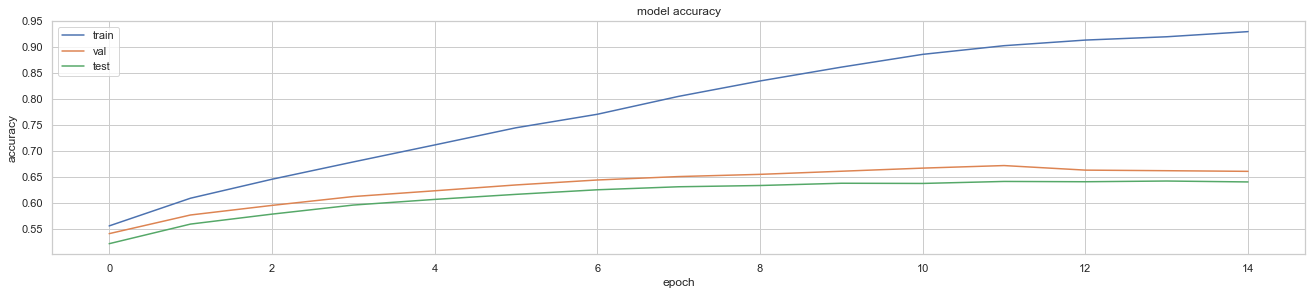

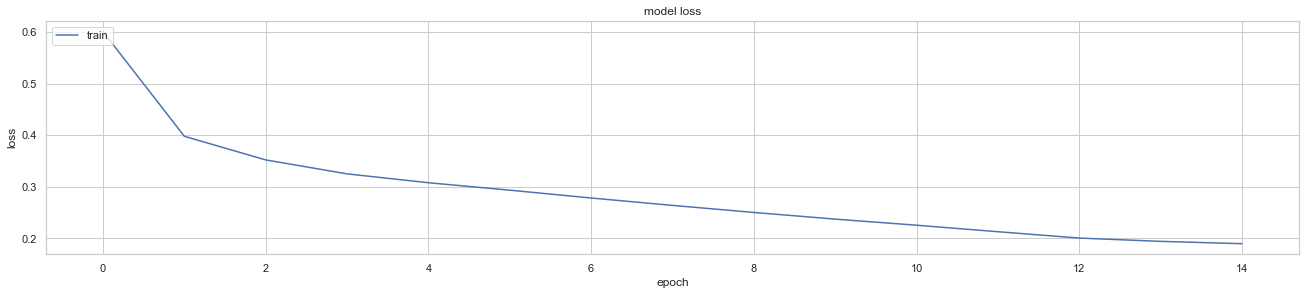

In [ ]:
# summarize history for accuracy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

plt.figure(figsize = (20,4))
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.plot(test_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.savefig('./accuracy_2.png')

# summarize history for loss
plt.figure(figsize = (20,4))
plt.plot(loss_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('./loss_2.png')